# 鋳造製品の欠陥検出

In [280]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

### ファイルパスの読み込み

In [281]:
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'

ROWS = 300
COLS = 300
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
random.shuffle(train_images)
train_def =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'def' in i]
train_ok =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'ok' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

print("train_image count:{}".format(len(train_images)))
print("def_image count:{}".format(len(train_def)))
print("ok_image count:{}".format(len(train_ok)))
print("test_image count:{}".format(len(test_images)))

train_image count:250
def_image count:150
ok_image count:100
test_image count:100


### イメージデータの読み込み

In [282]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return img


### 配列データに変換

In [283]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%50 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [284]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 250
Processed 50 of 250
Processed 100 of 250
Processed 150 of 250
Processed 200 of 250
Processed 0 of 100
Processed 50 of 100
Train shape: (250, 300, 300, 3)
Test shape: (100, 300, 300, 3)


### 正解ラベル

Text(0.5, 1.0, 'Defect detection')

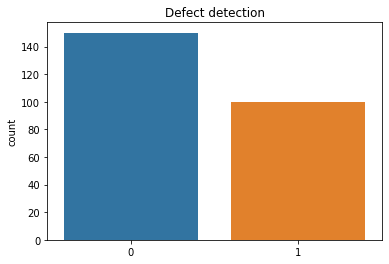

In [285]:
labels = []
for i in train_images:
    if 'ok' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Defect detection')

### イメージ表示

In [286]:
def show_defect(idx):
    defect = read_image(train_def[idx])
    ok = read_image(train_ok[idx])
    pair = np.concatenate((defect, ok), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

### 左が欠陥で右が正常

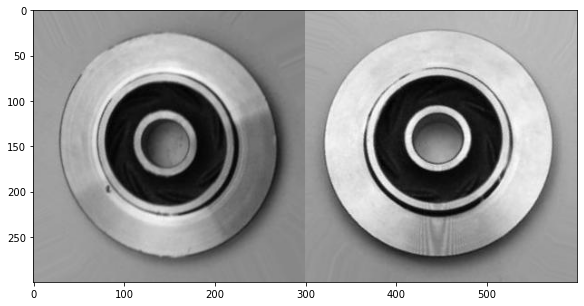

In [287]:
for idx in range(0,1):
    show_defect(idx)

In [288]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation,BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

### CNNの構築

In [289]:
def defectDetection():
    
    #CNN
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(optimizer=RMSprop(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


model = defectDetection()
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_173 (Conv2D)          (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 75, 75, 64)      

### 学習＆予測

In [290]:
epoch = 20

# 学習
history = model.fit(train, labels, batch_size=1, epochs=epoch,
          validation_split=0.25, verbose=1, shuffle=True)
# 予測
predictions = model.predict(test, verbose=0)


Train on 187 samples, validate on 63 samples
Epoch 1/20
187/187 [==============================] - 4s 24ms/step - loss: 3.7596 - accuracy: 0.5027 - val_loss: 0.8969 - val_accuracy: 0.6825
Epoch 2/20
187/187 [==============================] - 3s 18ms/step - loss: 2.1714 - accuracy: 0.5989 - val_loss: 0.6619 - val_accuracy: 0.7619
Epoch 3/20
187/187 [==============================] - 3s 18ms/step - loss: 1.4633 - accuracy: 0.7166 - val_loss: 0.7063 - val_accuracy: 0.6667
Epoch 4/20
187/187 [==============================] - 3s 18ms/step - loss: 1.3210 - accuracy: 0.6631 - val_loss: 0.8537 - val_accuracy: 0.6825
Epoch 5/20
187/187 [==============================] - 3s 18ms/step - loss: 1.2353 - accuracy: 0.6952 - val_loss: 0.9462 - val_accuracy: 0.7460
Epoch 6/20
187/187 [==============================] - 3s 18ms/step - loss: 1.2629 - accuracy: 0.7380 - val_loss: 0.9592 - val_accuracy: 0.7143
Epoch 7/20
187/187 [==============================] - 3s 18ms/step - loss: 1.0461 - accuracy: 0.7

### 結果の評価

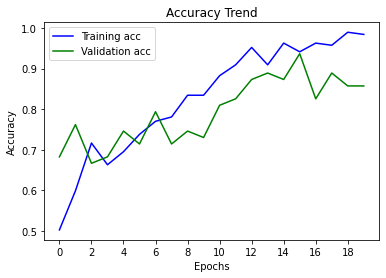

In [291]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.plot(history.epoch,acc, 'blue', label='Training acc')
plt.plot(history.epoch,val_acc, 'green', label='Validation acc')
plt.xticks(range(0,epoch)[0::2])
plt.legend()
plt.show()

### 予測したイメージを確認

=== Def ===


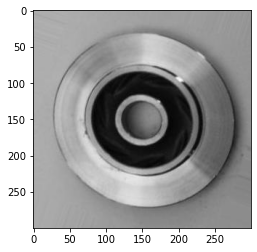

=== Def ===


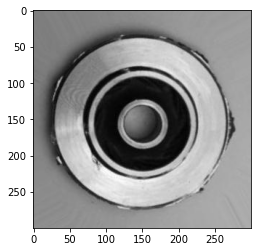

=== Def ===


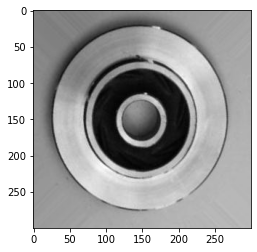

=== Def ===


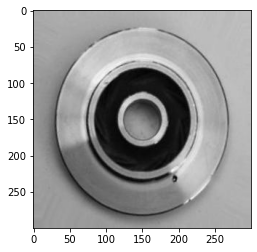

=== Def ===


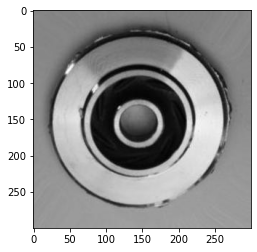

=== Def ===


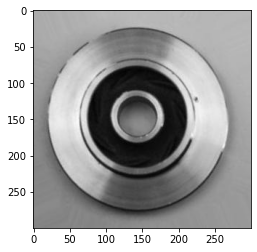

=== OK ===


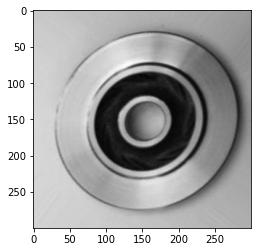

=== Def ===


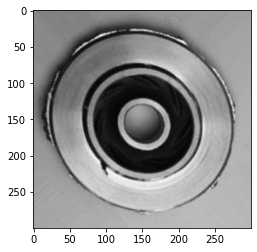

=== Def ===


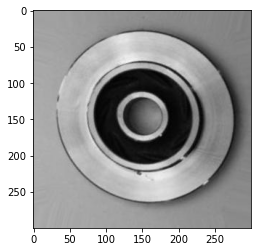

=== OK ===


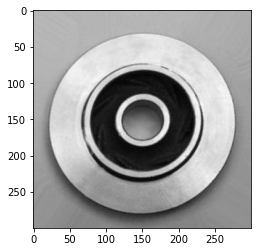

In [292]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('=== OK ==='.format(predictions[i][0]))
    else: 
        print('=== Def ==='.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [293]:
l =np.zeros(len(predictions),dtype=np.int64)
idx = 0
for t in predictions:
    if t >= 0.5:
        l[idx] = 1
    else:
        l[idx] = 0
    idx += 1

In [294]:
l

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

### 出力ファイル

In [295]:
sample = pd.read_csv("./sample_submission.csv",header=None)

In [296]:
for i,t in enumerate(test_images):
    # パスからファイル名を抽出
    basename = os.path.basename(t)
    # 同じファイル名に結果を入れる
    sample.loc[sample[0] == basename,1] = l[i]
    
sample.head(20)

,0,1
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,1
5,69975.jpeg,0
6,79963.jpeg,0
7,89914.jpeg,0
8,99851.jpeg,1
9,109996.jpeg,0


In [297]:
import csv
f = open('out.csv','w',newline='')
writer = csv.writer(f)
writer.writerows(sample.values)
f.close()